In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

from sparktorch import serialize_torch_obj, SparkTorch, PysparkPipelineWrapper
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import *
from pyspark.ml.pipeline import Pipeline, PipelineModel
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
import pyarrow.parquet as pq

import constant
import tools

In [2]:
def _load_parquet(path, schema:StructType = None):
    """
    load apache parquet file
    """
    return sqlContext.read.schema(schema).parquet(path) if schema is not None else sqlContext.read.parquet(path)

def _load_weather_toPandas(path, schema:StructType = None):
    """
    load apache parquet file
    """
    weather = _load_parquet(path) \
                    .withColumnRenamed("__index_level_0__", "TIME") \
                    .dropna() \
                    .withColumn("id", monotonically_increasing_id())
    weather.createOrReplaceTempView("weather_temp")
    weather_dic = spark.sql("select * from weather_temp where id in (select max(id) as id from weather_temp group by TIME)").toPandas()
    return weather_dic

def _load_csv(path, schema:StructType = None):
    """
    load csv file
    """
    return sqlContext.read.csv(path, sep=",", header=True, schema=schema)


def load_files():
# to read parquet file
    settlement = _load_parquet(constant.settlement_path, constant.settlement_schema)
    settlement = settlement.dropna(subset =["VAERDI"]) \
                .withColumn("VAERDI", settlement["VAERDI"].cast("float"))
                # .where("TIME_CET like '%:00:%'")
    
    windmill = _load_csv(constant.windmill_path, constant.windmills_schema)
    windmill = windmill.where("grid != 0").fillna(0.1)
    ws10_dic = _load_weather_toPandas(constant.ws10_path)
    ws100_dic = _load_weather_toPandas(constant.ws10_path)
    wd10_dic = _load_weather_toPandas(constant.wd10_path)
    wd100_dic = _load_weather_toPandas(constant.wd100_path)
    tools.get_udf(ws10_dic, ws100_dic, wd10_dic, wd100_dic)
    return settlement, windmill


def get_net_pipeline(inputCol, labelCol, lr, iters, input_size, hidden_size, output_size):
    # Setup features
    vec_assembler = VectorAssembler(inputCols=inputCol, outputCol="features")
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
    network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size)
        )    
    torch_obj = serialize_torch_obj(
        model=network,
        criterion=nn.MSELoss(),
        optimizer=torch.optim.Adam,
        lr=lr
    )
    # Create a SparkTorch Model with torch distributed. Barrier execution is on by default for this mode.
    spark_model = SparkTorch(
        inputCol='scaledFeatures',
        labelCol=labelCol,
        predictionCol='predictions',
        torchObj=torch_obj,
        iters=iters,
        verbose=1
    )
    # Can be used in a pipeline and saved.
    return Pipeline(stages=[vec_assembler, scaler, spark_model])

In [25]:
class NN(nn.Module):

  def __init__(self, input_size, hidden_size, output_size):
    super(NN, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, hidden_size)
    self.fc3 = nn.Linear(hidden_size, output_size)
    self.d = nn.Dropout(p=0.2)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.d(x)
    x = F.relu(self.fc2(x))
    x = self.d(x)
    x = self.fc3(x)

    return x

In [26]:
def train_model(
  model, 
  lr,
  num_epochs,
  X_train, 
  y_train, 
  X_test=None, 
  y_test=None
):
  loss_fn = torch.nn.MSELoss()

  optimiser = torch.optim.Adam(model.parameters(), lr=lr)
  num_epochs = num_epochs

  train_hist = np.zeros(num_epochs)
  test_hist = np.zeros(num_epochs)

  for t in range(num_epochs):
    # RNN
    # model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if X_test is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:  
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
  
  return model.eval(), train_hist, test_hist

In [5]:
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("WindTurbine_ws") \
        .config("spark.driver.memory","10g") \
        .config("spark.executor.memory","8g") \
        .getOrCreate()

sc = spark.sparkContext
sqlContext = SQLContext(sc)

In [6]:
settlement, windmill = load_files()
settlement.persist()

DataFrame[GSRN: string, VAERDI: float, TIME_CET: string]

In [7]:
windmill = windmill.where("Turbine_type = 'W'").where("Placement = 'LAND'")
windmill.persist()

DataFrame[GSRN: string, Turbine_type: string, Parent_GSRN: string, BBR_municipal: string, Placement: string, UTM_x: string, UTM_y: string, Capacity_kw: float, Rotor_diameter: float, Navhub_height: float, grid: string, grid_in_range: string, Land_cover: float, Slope: float, roughness: float]

In [8]:
windmill.count()

4178

In [9]:
train = settlement.where("TIME_CET not like '2019-03-31 02%'").where("TIME_CET not like '2019-12-30%'") \
    .sample(fraction=0.01, seed=5)
train = tools.upscaling(train, windmill)

In [10]:
train.write.save("data/upscaling_train.parquet", format="parquet")

In [11]:
test = settlement.where("TIME_CET like '2019-12-30%'")
test = tools.upscaling(test, windmill)

In [12]:
test.write.save("data/upscaling_test.parquet", format="parquet")

In [13]:
spark.stop()

# Train Model

In [5]:
train_pd = pq.read_table("data/upscaling_train.parquet").to_pandas()

In [6]:
test_pd = pq.read_table("data/upscaling_test.parquet").to_pandas()

In [15]:
VAERDI = train_pd[["VAERDI"]]

In [7]:
VAERDI = VAERDI[VAERDI["VAERDI"]>1000]

NameError: name 'VAERDI' is not defined

In [27]:
VAERDI = VAERDI.append(VAERDI[VAERDI["VAERDI"]>3500])

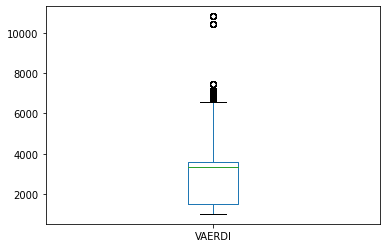

In [28]:
VAERDI.plot.box()

In [29]:
VAERDI.describe()

,VAERDI
count,14664.000000
mean,2907.457526
std,1538.425685
min,1000.199982
25%,1489.397537
50%,3358.250000
75%,3569.100098
max,10841.834991


In [323]:
VAERDI_large = train_pd[["VAERDI"]]

In [135]:
VAERDI_large = VAERDI_large[VAERDI_large["VAERDI"]>3200]

In [136]:
VAERDI_large.describe()

,VAERDI
count,87.000000
mean,3457.696940
std,113.487526
min,3205.500000
25%,3411.399902
50%,3440.800049
75%,3550.799927
max,3962.935089


In [8]:
train_pd = train_pd[train_pd["VAERDI"]>1700]

In [9]:
train_pd = train_pd.append(train_pd[train_pd["VAERDI"]>3500])

In [10]:
train_pd = train_pd.append(train_pd)

In [52]:
train_pd["VAERDI"].describe()

count    12822.000000
mean      3396.340790
std       1270.672034
min       1700.500000
25%       2396.225048
50%       3540.399902
75%       3598.594971
max      10841.834991
Name: VAERDI, dtype: float64

In [27]:
feat_cols = ["mins","hour", "Slope","roughness","ws10", "ws100","wd10","wd100"]
# feat_cols = ["mins","hour", "ws10", "ws100","wd10","wd100"]
x_train = train_pd[feat_cols]
y_train = train_pd[["VAERDI"]]
x_test = test_pd[feat_cols]
y_test = test_pd[["VAERDI"]]
timeline = test_pd[["TIME_CET"]]

In [28]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

dtype = torch.float
x_train_tensor = torch.tensor(x_train, dtype = dtype)
x_test_tensor = torch.tensor(x_test, dtype = dtype)
y_train_tensor = torch.tensor(y_train.values, dtype = dtype)
y_test_tensor = torch.tensor(y_test.values, dtype = dtype)

In [29]:
model = NN(
  input_size=8,
  hidden_size=400,
  output_size=1
)
model, train_hist, test_hist = train_model(
  model, 
  0.2,
  100,
  x_train_tensor, 
  y_train_tensor, 
  x_test_tensor, 
  y_test_tensor
)

Epoch 0 train loss: 9199572.0 test loss: 34903696.0
Epoch 10 train loss: 8356889.5 test loss: 34446140.0
Epoch 20 train loss: 3209300.75 test loss: 30783308.0
Epoch 30 train loss: 1726657.375 test loss: 27784764.0
Epoch 40 train loss: 1206176.5 test loss: 26468426.0
Epoch 50 train loss: 1011309.0625 test loss: 25890570.0
Epoch 60 train loss: 961444.0625 test loss: 25789356.0
Epoch 70 train loss: 931501.1875 test loss: 25723400.0
Epoch 80 train loss: 920883.3125 test loss: 25640604.0
Epoch 90 train loss: 901029.1875 test loss: 25645100.0


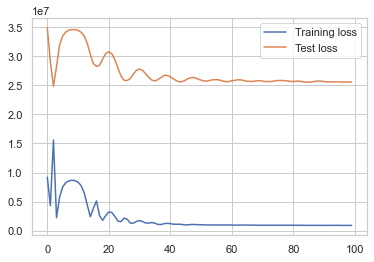

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.plot(train_hist, label="Training loss")
plt.plot(test_hist, label="Test loss")
plt.legend()

In [31]:
y_pred_tensor = model(x_test_tensor)
y_pred = y_pred_tensor.detach().numpy()
y_test["pred"] = pd.Series(y_pred.tolist()).apply(lambda x: x[0])
y_test["time"] = pd.Series(timeline["TIME_CET"])
y_test = y_test.groupby(y_test["time"]).agg({"VAERDI":lambda x:sum(x), "pred":lambda x:sum(x)}).reset_index()

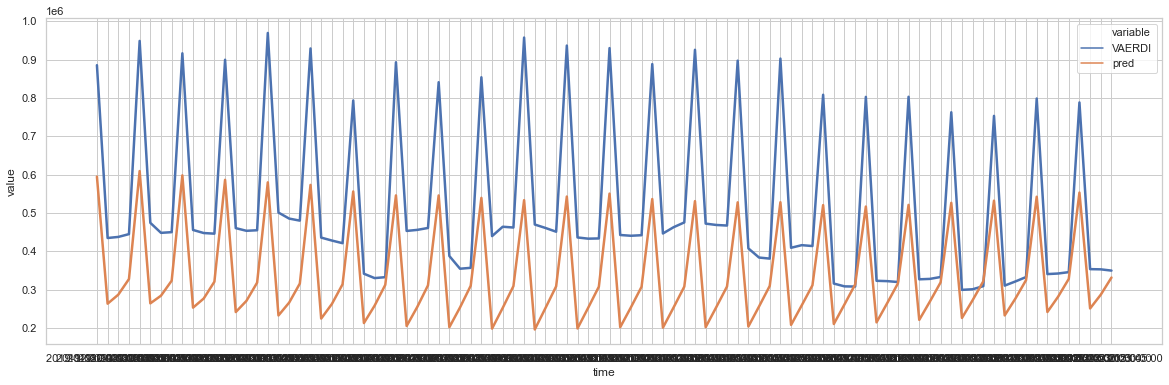

In [32]:
plt.figure(figsize=(20,6))
sns.set(style="whitegrid")
sns.lineplot(x="time",  y="value", data=pd.melt(y_test, ['time']), hue='variable',linewidth=2.5)